# Kernel Density Estimation
### by [Richard W. Evans](https://sites.google.com/site/rickecon/), April 2020
The code in this Jupyter notebook was written using Python 3.7.

A kernel density estimator (KDE) is a nonparametric estimator that can be used as an unsupervised learning model for data of any dimension (however, there are computational limits to how many dimensions of variable can be estimated as a KDE). But KDE's are especially effective at estimating distributions. KDE's also have the property of smoothing data. It is in this sense that KDE's have some similar properties to the spline functions we studied last term. We have also seen what the term "kernel" means in our study of the [support vector machines (SVM) classifier](https://github.com/UC-MACSS/persp-model-econ_W20/blob/master/Notebooks/SVM/SVM.ipynb), where the kernel is some root function that gets repeatedly used to put some structure on the data.

In the [maximum likelihood estimation (MLE)](https://github.com/rickecon/Notebooks/blob/master/MLE/MLest.ipynb) and [generalized method of moments (GMM)](https://github.com/rickecon/Notebooks/blob/master/GMM/GMMest.ipynb) notebooks from last term, we estimated the parameters of flexible parametric distributions to fit the data. With KDE, we are doing the same thing with nonparametric distributions.

Some excellent resources on kernel density estimation are VanderPlas (2017, pp. 491-506), Scott (2015, ch. 6), and Hastie, et al (2009, ch. 6). I recommend buying all three books. Especially valuable is the vast repository of Jupyter notebooks (and Google Colab served notebooks) that correspond to the chapters in VanderPlas (2017).

## 1. KDE intuition from histogram
See VanderPlas (2017) KDE notebook using [Google Colab](https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.13-Kernel-Density-Estimation.ipynb) or from the [VanderPlas (2017) GitHub repository](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.13-Kernel-Density-Estimation.ipynb).

## 2. KDE mathematical specification

### 2.1. Mathematical specification
See Hastie, et al (2009, Section 6.6). A type of "averaged shifted histogram" estimator as described in Scott (2015, p. 138) is the following,

$$ \hat{f}_{X}(x_0) = \frac{{\#}x_i\in\mathcal{N}(x_0)}{N\lambda} $$

where $\mathcal{N}(x_0)$ is a small metric neighborhood around $x_0$ of width $\lambda$. Another way to write this is:

$$ \hat{f}_{X}(x_0) = \frac{\sum_{i}\mathcal{I}\Bigl(\text{abs}(x_i - x_0) < \frac{\lambda}{2}\Bigr)}{N\lambda} $$

You can think of the function in the numerator as a uniform distribution of length $\lambda$ and height of 1 centered around $x_0$.

A more general function in the numerator is called a kernel. Different kernels can provide different shapes, properties, and smoothness,

$$ \hat{f}_{X}(x_0) = \frac{1}{N\lambda}\sum_{i}K_\lambda(x_0,x_i) $$

where $K_\lambda(x_0,x_i)$ is the kernel function.

Intuitively, the KDE is placing a distribution around each point of the data, then cumulatively adding up all the distributions and normalizing the height of the resulting distribution to sum to one, resulting in a "somewhat" smooth estimate of the PDF.

Six prominent kernel functions are used in Sci-kit Learn's [kernel density estimation function](http://scikit-learn.org/stable/modules/density.html): tophat (uniform), Gaussian, Epanechnikov, exponential, linear (hat), and cosine. 

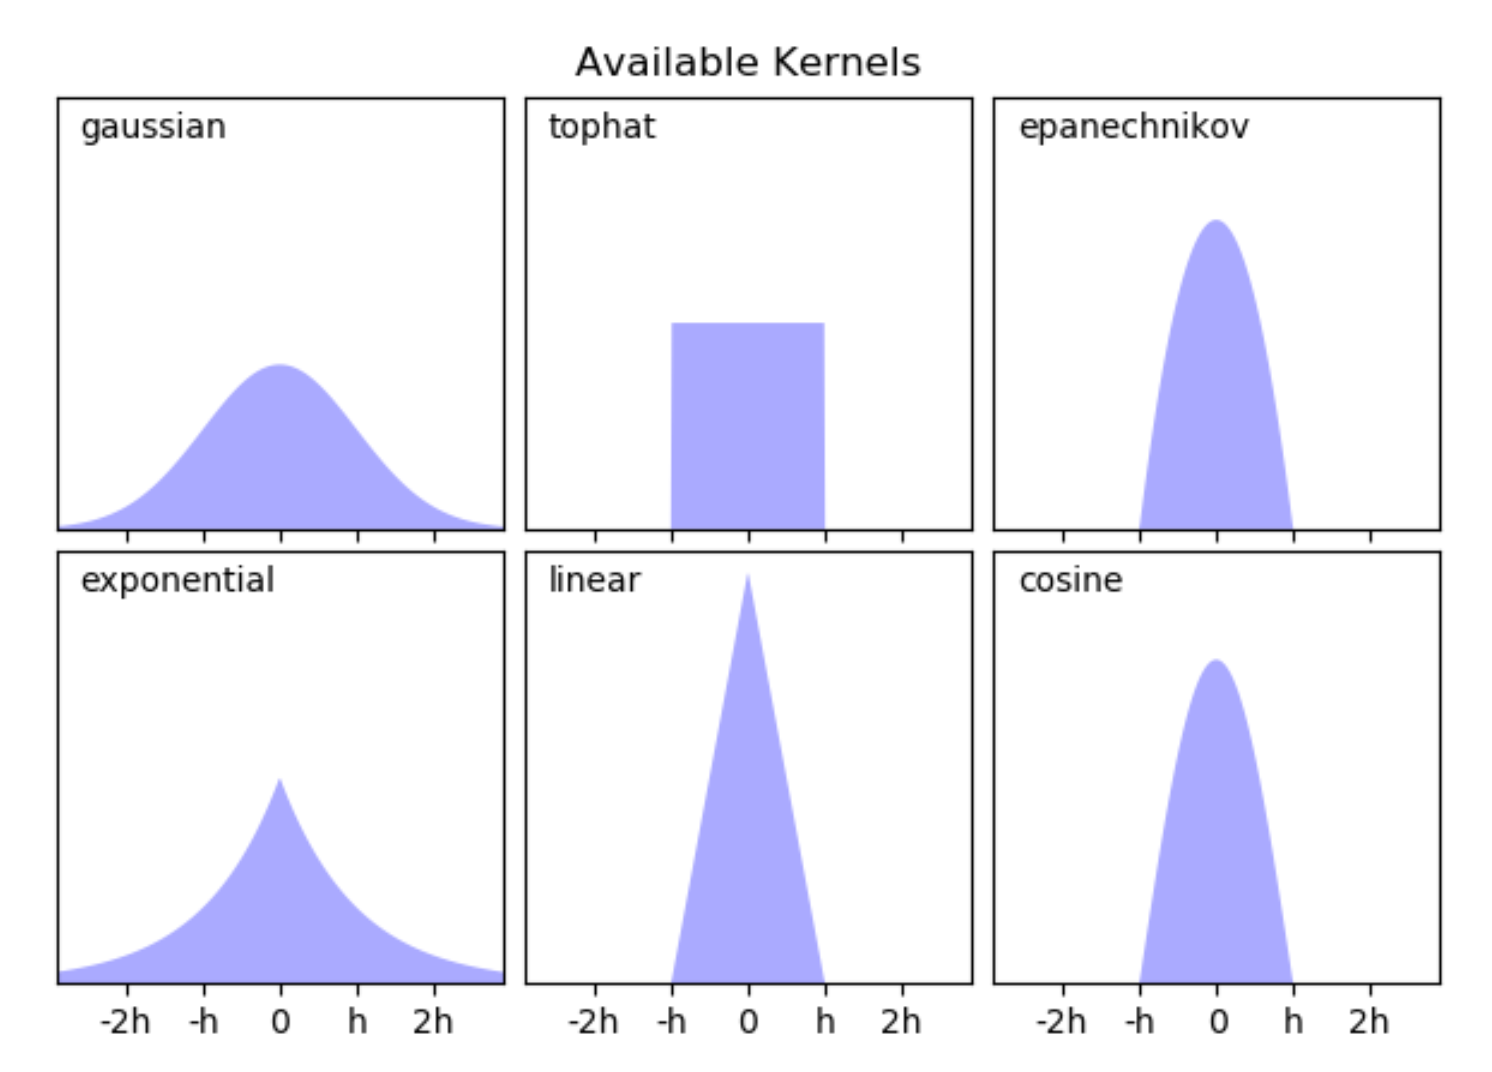

### 2.2. Why do we want smoothness?
When we look at empirical histograms, the bin boundaries and number of bins are arbitrary. There is no reason to think that the discontinuities at the bin boundaries represent true features of the underlying data generating process, unless there is some structural reason for a particular boundary. The KDE estimator generates a smoothed estimate of the PDF of some data, with some kind of bandwidth parameter.

In the tophat kernel, the bandwidth is the width $\lambda$ of the $n$-dimensional uniform distribution around each point. In the Gaussian kernel, the bandwidth is the variance $\Sigma$ of the $n$-dimensional Gaussian distribution centered around each point. As you will see in the examples below, a very high bandwidth will give the estimated KDE the most smoothness. On the other hand, a high bandwidth might smooth out relevant features of the data.

The bandwith parameter in a KDE is an ideal parameter to tune based on some criterion of some use of the underlying data.

## 3. Python KDE implementations
Python has four main packages for executing a kernel density estimation.

1. SciPy [scipy.stats.gaussian_kde](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gaussian_kde.html)
2. scikit-learn [sklearn.neighbors.KernelDensity](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KernelDensity.html)
3. statsmodels [statsmodels.nonparametric.kde.KDEUnivariate](https://www.statsmodels.org/stable/generated/statsmodels.nonparametric.kde.KDEUnivariate.html) and [statsmodels.nonparametric.kernel_density.KDEMultivariate](https://www.statsmodels.org/stable/generated/statsmodels.nonparametric.kernel_density.KDEMultivariate.html)
4. [KDEpy](https://kdepy.readthedocs.io/en/latest/#)

KDEpy has very good documentation along with an extremely valuable [comparison page](https://kdepy.readthedocs.io/en/latest/comparison.html) that compares the performance of all four packages across a number of dimensions.

## 4. Examples


### 4.1. Two-dimensional data: Old Faithful geyser duration
The following `geyser.csv` dataset includes 107 measurements of the duration of an eruption of the Old Faithful geyser in Yellowstone National Park.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# This next command is specifically for Jupyter Notebook
#%matplotlib notebook

geyser_dur = pd.read_csv('data/geyser.csv', names =['duration'])

If we describe the `geyer_dur` duration variable, we see that the average duration is 3.45 minutes.

In [2]:
geyser_dur.describe()

,duration
count,107.000000
mean,3.459907
std,1.040295
min,1.670000
25%,2.300000
50%,3.800000
75%,4.250000
max,4.930000


A univariate histogram of these data looks pretty lumpy, with a clump around 4 minutes and a clump of short eruption lengths less than two minutes.

Text(0, 0.5, 'Percent of observations in bin')

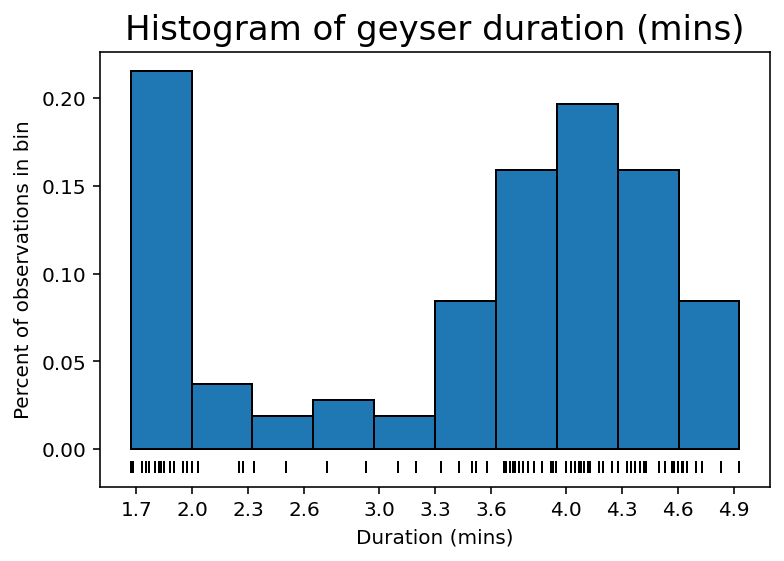

In [3]:
num_bins = 10
dur_vals = geyser_dur.values
weights = (1 / dur_vals.shape[0]) * np.ones_like(dur_vals)
n, bin_cuts, patches = plt.hist(dur_vals, num_bins, weights=weights, edgecolor='k')
plt.plot(dur_vals, np.full_like(dur_vals, -0.01), '|k', markeredgewidth=1)
plt.xticks(np.round_(bin_cuts, 1))
plt.title('Histogram of geyser duration (mins)', fontsize=17)
plt.xlabel(r'Duration (mins)')
plt.ylabel(r'Percent of observations in bin')

Now let's look at how things change when we look at the persistence of eruption duration length by looking at a 2-D histogram of eruption durations in period-t and eruption duration in periot-(t+1).

In [5]:
dur_t = geyser_dur['duration'][:-1]
dur_t = pd.Series(dur_t, name='dur_t')
dur_tp1 = geyser_dur['duration'].shift(-1).dropna()
dur_tp1 = pd.Series(dur_tp1, name='dur_tp1')

To make a 2D histogram using matplotlib, you have to use the NumPy function `histogram2d()` and then port the objects into a 3D bar chart using matplotlib's `bar3D()` function.

Text(0.5, 0.92, 'Histogram by Old Faithful duration(t) and duration(t-1)')

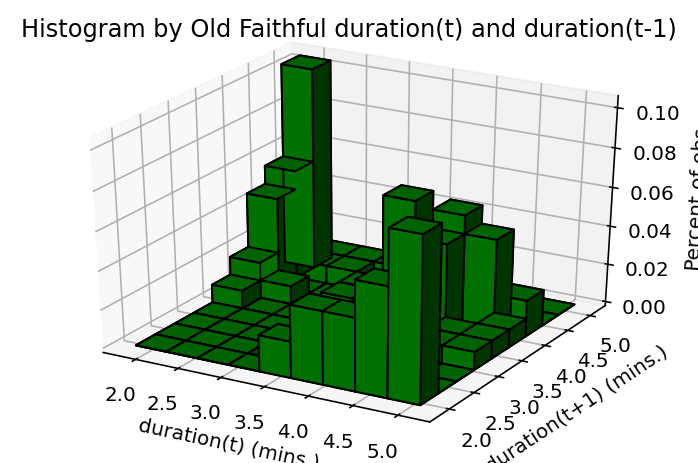

In [6]:
'''
--------------------------------------------------------------------
bin_num  = integer > 2, number of bins along each axis
hist     = (bin_num, bin_num) matrix, bin percentages
xedges   = (bin_num+1,) vector, bin edge values in x-dimension
yedges   = (bin_num+1,) vector, bin edge values in y-dimension
x_midp   = (bin_num,) vector, midpoints of bins in x-dimension
y_midp   = (bin_num,) vector, midpoints of bins in y-dimension
elements = integer, total number of 3D histogram bins
xpos     = (bin_num * bin_num) vector, x-coordinates of each bin
ypos     = (bin_num * bin_num) vector, y-coordinates of each bin
zpos     = (bin_num * bin_num) vector, zeros or z-coordinates of
            origin of each bin
dx       = (bin_num,) vector, x-width of each bin
dy       = (bin_num,) vector, y-width of each bin
dz       = (bin_num * bin_num) vector, height of each bin
--------------------------------------------------------------------
'''
fig = plt.figure()
ax = fig.add_subplot(111, projection ='3d')
bin_num = int(9)
hist, xedges, yedges = np.histogram2d(dur_t, dur_tp1, bins=bin_num)
hist = hist / hist.sum() # Normalize so that the percentages sum to 1

x_midp = xedges[:-1] + 0.5 * (xedges[1] - xedges[0])
y_midp = yedges[:-1] + 0.5 * (yedges[1] - yedges[0])
elements = (len(xedges) - 1) * (len(yedges) - 1)
ypos, xpos = np.meshgrid(y_midp, x_midp)
xpos = xpos.flatten()
ypos = ypos.flatten()
zpos = np.zeros(elements)
dx = (xedges[1] - xedges[0]) * np.ones_like(bin_num)
dy = (yedges[1] - yedges[0]) * np.ones_like(bin_num)
dz = hist.flatten()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color='g', zsort='average', edgecolor='k')
ax.set_xlabel('duration(t) (mins.)')
ax.set_ylabel('duration(t+1) (mins.)')
ax.set_zlabel('Percent of obs.')
plt.title('Histogram by Old Faithful duration(t) and duration(t-1)')

A KDE will fit a smooth function to this histogram that should tell us a "finer grained" story about how eruption duration today influences eruption duration tomorrow.

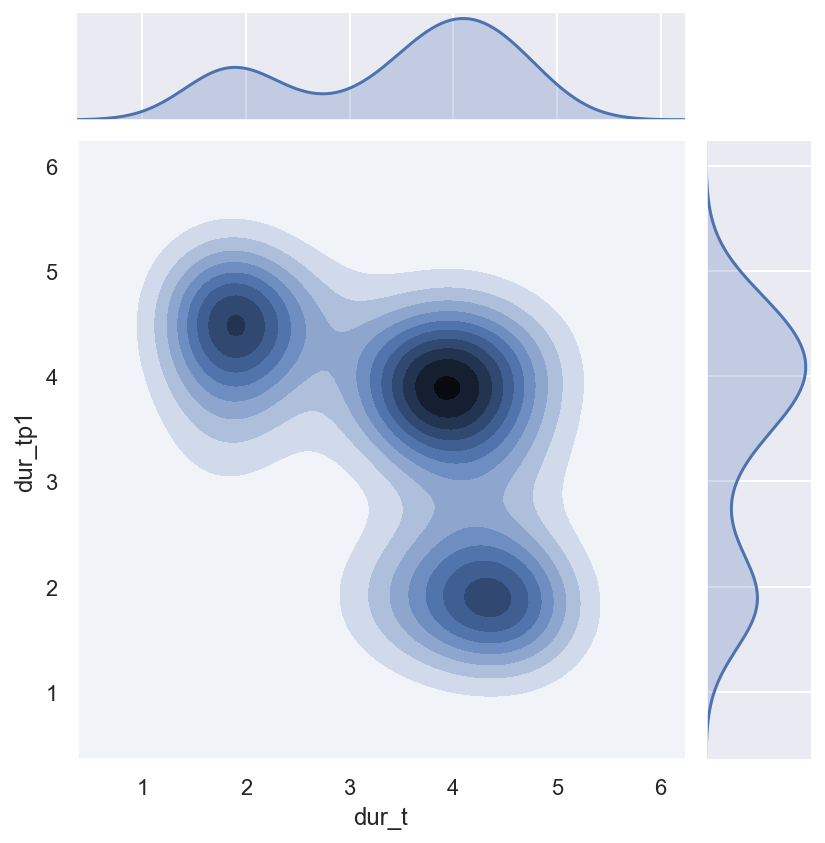

In [8]:
import seaborn as sns
sns.set(color_codes=True)

dur_t_tp1 = pd.concat([dur_t, dur_tp1], axis=1)
# dur_t_tp1
# dur_t_tp1_trunc = dur_t_tp1[1:-1]
# dur_t_tp1_trunc
sns.jointplot(x="dur_t", y="dur_tp1", data=dur_t_tp1, kind="kde")

If we want to control the bandwidth and plot the surface as a KDE smoothed version of the joint distribution, we can use the following code.

Text(0.5, 0, 'Percent of eruptions')

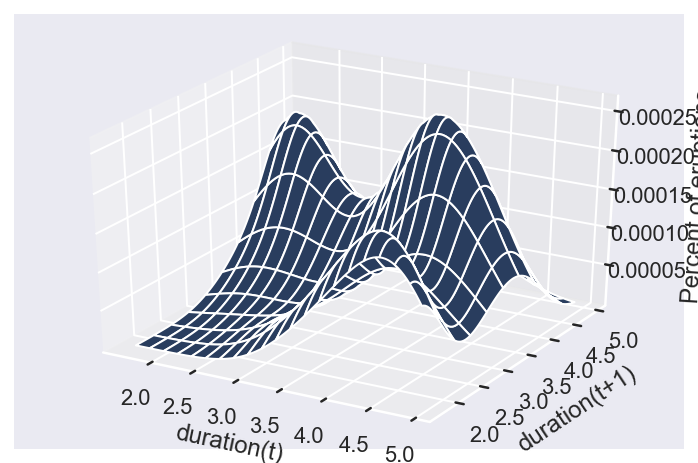

In [9]:
from scipy.stats import gaussian_kde

bandwidth = 0.5
kernel = gaussian_kde(dur_t_tp1.T, bw_method=bandwidth)

dur_t_min = dur_t.min()
dur_t_max = dur_t.max()
dur_tp1_min = dur_tp1.min()
dur_tp1_max = dur_tp1.max()

dur_t_i, dur_tp1_i = np.mgrid[dur_t_min:dur_t_max:100j,
                              dur_tp1_min:dur_tp1_max:100j]
coords = np.vstack([item.ravel() for item in [dur_t_i, dur_tp1_i]])

# kernel(coords)

Z = np.reshape(kernel(coords), dur_t_i.shape)
Z_scaled = Z / float(np.sum(Z))

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(dur_t_i, dur_tp1_i, Z_scaled, rstride=5)
ax.set_xlabel("duration(t)")
ax.set_ylabel("duration(t+1)")
ax.set_zlabel("Percent of eruptions")

### 4.2. Two-dimensional data: bequests (inheritances)

The following data are from Italy. They represent the percent of bequests (inheritances) each year that are received by Italian individuals by age and by lifetime income group.

In [ ]:
# Import the rough bequest distribution matrix and transpose it
BQ_mat_raw = np.loadtxt('data/BQ_mat_raw_ITA.txt', delimiter=',').T

# Some diagnostics
print('Shape of BQ_mat_raw', BQ_mat_raw.shape)
print('Bequest distribution by income group:',
      BQ_mat_raw.sum(axis=0))
print('Sum of all probabilities', BQ_mat_raw.sum())

Because the sum of all probabilities is not exactly equal to 1.0, I rescale the matrix.

In [ ]:
# Because the sum of all probabilities is not exactly equal
# to 1.0, I rescale the matrix.
BQ_mat_raw = BQ_mat_raw / BQ_mat_raw.sum()
print(BQ_mat_raw.sum())

# Make 3D surface plot of rough bequests distribution matrix
age_vec = np.arange(30, 81)
lambdas = np.array([0.25, 0.25, 0.20, 0.10, 0.10, 0.09, 0.01])
lambdas_mdpts = np.array([0.125, 0.375, 0.60, 0.75, 0.85,
                          0.94, 0.995])
income_mat, age_mat = np.meshgrid(lambdas_mdpts, age_vec)

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(age_mat, income_mat, BQ_mat_raw)
ax.set_title('Raw distribution of bequest recipient proportion')
ax.set_xlabel('Age')
ax.set_ylabel('Ability Types')
ax.set_zlabel('Percent of BQ received')

I don't believe that the percent of bequests really jumps around from age to age like we see in this data. In your kernel density estimation exercise in Problem Set 2, you will fit a smoothed density to the U.S. version of these data.

### 4.3. Synthetic data creation
In a current project involving the Open Source Economics Laboratory, Tax Policy Center, and U.S. Internal Revenue Service, we are developing a method for creating synthetic data sets that have similar statistical properties of the original dataset and also have a high degree of privacy protection.

Suppose that a dataset has $N$ observations on $K$ variables $X \equiv (x_1, x_2,...x_K)$. Define the true joint distribution over the $K$ variables as $f(X)\equiv f(x_1, x_2,...x_K)$. Every approach to creating synthetic data involves estimating the joint distribution over all the $K$ variables $\hat{f}(X)$ and then sampling $N$ observations from that estimated distribution.

#### 4.3.1. K-dimensional histogram
The first approach that a researcher might take is to estimate an $K$-dimensional histogram over each of the variables.

#### 4.3.2. Bayes rule, cascading conditional distributions
Bayes rule states that a joint distribution is equal to a conditional distribution times the joint distribution of the conditioned variables.
\begin{equation}
  f(X, Y) = f(X|Y)f(Y)
\end{equation}

One could, in theory, estimate 

#### 4.3.3. Overlapping high dimensional KDE joint distributions
Our approach is to estimate overlapping KDE joint distributions of up to 8-dimensions each.

## 5. References
* Hastie, Trevor, Robert Tibshirani, and Jerome Friedman, *The Elements of Statistical Learning: Data Mining, Inference, and Prediction*, 2nd edition, Springer (2009).
* Scott, David W., *Multivariate Density Estimation: Theory, Practice, and Visualization*, 2nd edition, Wiley (2015).
* VanderPlas, Jake, *Python Data Science Handbook: Essential Tools for Working with Data*, O'Reilly (2017).